>>> BAGGING AİLESİ (ExtraTrees & Bagging) SAHNEYE ÇIKIYOR...

🔍 Feature Selection: En iyi 10 özellik seçiliyor...
✅ Seçim Tamamlandı.
------------------------------------------------------------

⏳ Model Eğitiliyor: 1. ExtraTreesClassifier (Dengesiz Veri Dostu) ...
✅ BİTTİ! (12.5 sn)
MODEL: 1. ExtraTreesClassifier (Dengesiz Veri Dostu)
Accuracy: %69.34 | ROC AUC: 0.6758 | F1: 0.6961
--------------------------------------------------
              precision    recall  f1-score   support

  Çözülemedi       0.48      0.52      0.50     37875
     Çözüldü       0.79      0.77      0.78     89816

    accuracy                           0.69    127691
   macro avg       0.64      0.64      0.64    127691
weighted avg       0.70      0.69      0.70    127691



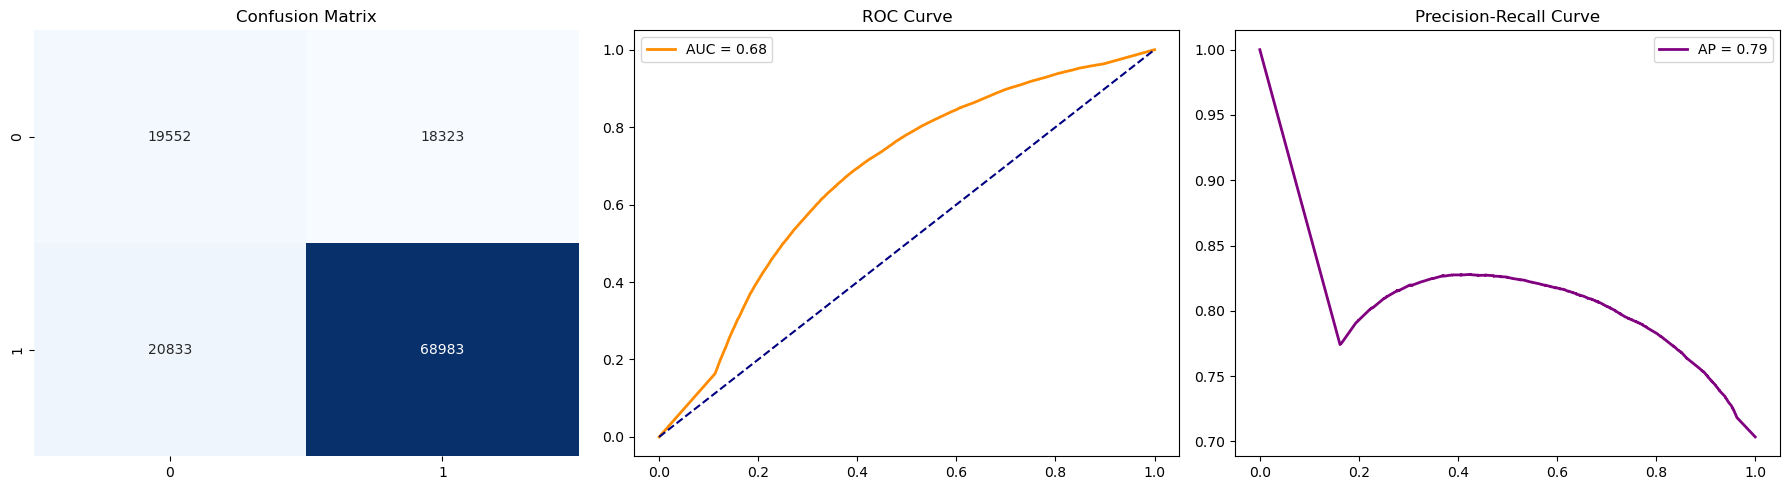


############################################################

⏳ Model Eğitiliyor: 2. BaggingClassifier (Standart) ...
✅ BİTTİ! (25.0 sn)
MODEL: 2. BaggingClassifier (Standart)
Accuracy: %70.72 | ROC AUC: 0.6922 | F1: 0.6987
--------------------------------------------------
              precision    recall  f1-score   support

  Çözülemedi       0.51      0.42      0.46     37875
     Çözüldü       0.77      0.83      0.80     89816

    accuracy                           0.71    127691
   macro avg       0.64      0.62      0.63    127691
weighted avg       0.69      0.71      0.70    127691



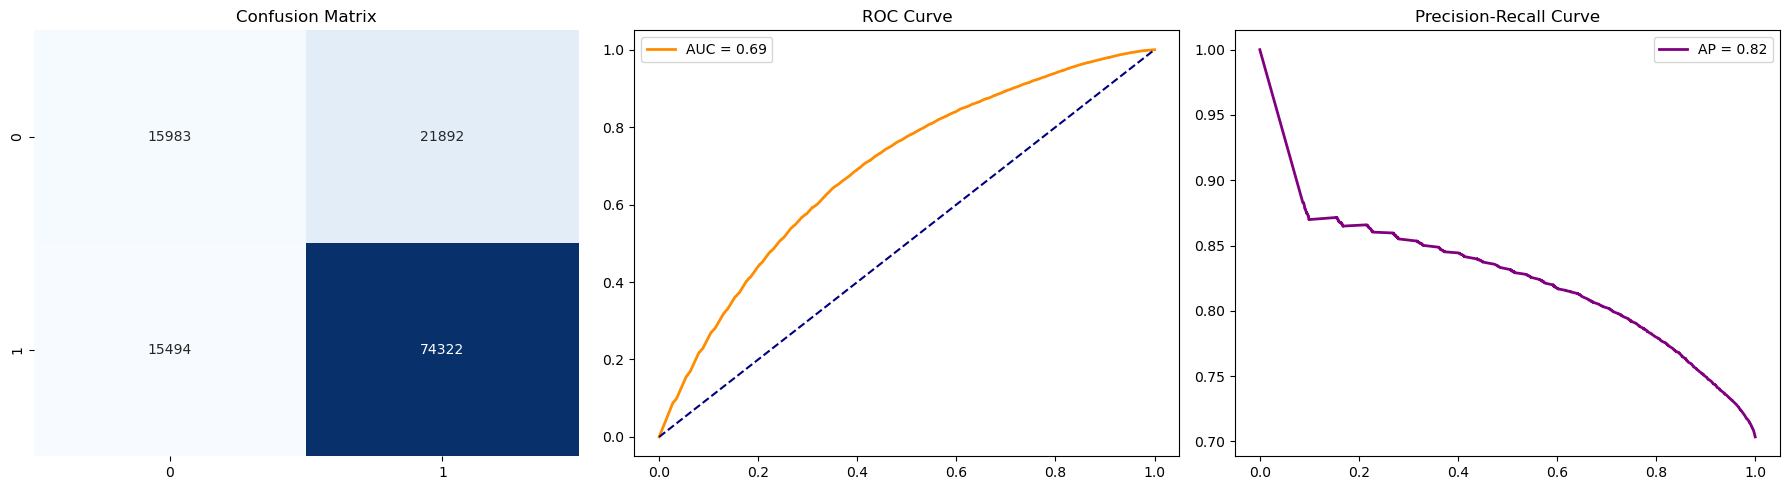


############################################################


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier, BaggingClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve, average_precision_score, f1_score

import warnings
warnings.filterwarnings('ignore')

print(">>> BAGGING AİLESİ (ExtraTrees & Bagging) SAHNEYE ÇIKIYOR...\n")

# ---------------------------------------------------------
# 1. VERİ HAZIRLIĞI & MÜHENDİSLİK
# ---------------------------------------------------------
df = pd.read_csv('US_Crime_DataSet.csv', low_memory=False)

drop_cols = ['Record ID', 'Agency Code', 'Incident', 'Record Source',
             'Victim Ethnicity', 'Victim Count', 'Perpetrator Ethnicity', 'Perpetrator Count',
             'Perpetrator Sex', 'Perpetrator Age', 'Perpetrator Race', 'Relationship']
df = df.drop(columns=[c for c in drop_cols if c in df.columns])
df['Crime Solved'] = df['Crime Solved'].map({'Yes': 1, 'No': 0})
df['Victim Age'] = pd.to_numeric(df['Victim Age'], errors='coerce').fillna(30)

# Feature Engineering
def get_season(month):
    if month in [12, 1, 2]: return 'Winter'
    elif month in [3, 4, 5]: return 'Spring'
    elif month in [6, 7, 8]: return 'Summer'
    else: return 'Fall'
df['Season'] = df['Month'].apply(get_season)

bins = [0, 18, 29, 59, 120]
labels = ['Child', 'Young_Adult', 'Adult', 'Senior']
df['Age_Group'] = pd.cut(df['Victim Age'], bins=bins, labels=labels, right=True).astype(object).fillna('Unknown')

regions = {
    'West': ['WA', 'OR', 'CA', 'NV', 'ID', 'MT', 'WY', 'UT', 'AZ', 'NM', 'CO', 'AK', 'HI'],
    'Midwest': ['ND', 'SD', 'NE', 'KS', 'MN', 'IA', 'MO', 'WI', 'IL', 'IN', 'MI', 'OH'],
    'South': ['TX', 'OK', 'AR', 'LA', 'MS', 'AL', 'TN', 'KY', 'WV', 'VA', 'NC', 'SC', 'GA', 'FL', 'DE', 'MD', 'DC'],
    'Northeast': ['PA', 'NY', 'NJ', 'CT', 'RI', 'MA', 'VT', 'NH', 'ME']
}
state_to_region = {state: region for region, states in regions.items() for state in states}
df['Region'] = df['State'].map(state_to_region).fillna('Other')

# Encoding
cat_cols = df.select_dtypes(include=['object']).columns
for col in cat_cols:
    df[col] = df[col].fillna('Unknown')
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))

X = df.drop('Crime Solved', axis=1)
y = df['Crime Solved']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 2. FEATURE SELECTION
print("🔍 Feature Selection: En iyi 10 özellik seçiliyor...")
fs = SelectFromModel(DecisionTreeClassifier(max_depth=10, random_state=42), max_features=10)
fs.fit(X_train_raw, y_train)
X_train = fs.transform(X_train_raw)
X_test = fs.transform(X_test_raw)
print(f"✅ Seçim Tamamlandı.")
print("-" * 60)

# ---------------------------------------------------------
# 3. MODELLER VE DÖNGÜ
# ---------------------------------------------------------
bagging_models = {
    "1. ExtraTreesClassifier (Dengesiz Veri Dostu)": ExtraTreesClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1),
    "2. BaggingClassifier (Standart)": BaggingClassifier(n_estimators=50, random_state=42, n_jobs=-1)
}

for name, model in bagging_models.items():
    print(f"\n⏳ Model Eğitiliyor: {name} ...")
    start = time.time()
    model.fit(X_train, y_train)
    elapsed = time.time() - start
    
    # Tahminler
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    # Metrikler
    acc = accuracy_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_prob)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f"✅ BİTTİ! ({elapsed:.1f} sn)")
    print("="*50)
    print(f"MODEL: {name}")
    print(f"Accuracy: %{acc*100:.2f} | ROC AUC: {roc:.4f} | F1: {f1:.4f}")
    print("-" * 50)
    print(classification_report(y_test, y_pred, target_names=['Çözülemedi', 'Çözüldü']))
    
    # --- GRAFİKLER ---
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0], cbar=False)
    axes[0].set_title(f'Confusion Matrix')
    
    # ROC
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc:.2f}')
    axes[1].plot([0, 1], [0, 1], color='navy', linestyle='--')
    axes[1].set_title('ROC Curve')
    axes[1].legend()

    # Precision-Recall
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    avg_prec = average_precision_score(y_test, y_prob)
    axes[2].plot(recall, precision, color='purple', lw=2, label=f'AP = {avg_prec:.2f}')
    axes[2].set_title('Precision-Recall Curve')
    axes[2].legend()
    
    plt.tight_layout()
    plt.show()
    print("\n" + "#"*60)